### Libraries

In [9]:
import cv2 as cv
import time
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from functions import * # own functions

### Capture an image
Here we are going to use our laptop camera to take a picture and save it into the folder of images

Taking picture in 2 seconds...
Image saved at images/selfie.jpg


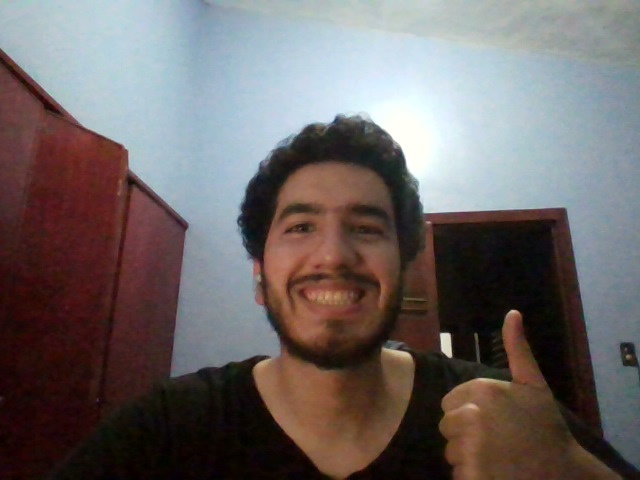

In [10]:
delay = 2
img_path = "images/selfie.jpg"

cap = cv.VideoCapture(0)
print(f"Taking picture in {delay} seconds...")
time.sleep(delay)
ret, frame = cap.read()
if ret:    
    cv.imwrite(img_path, frame)
    print(f"Image saved at {img_path}")
else:
    print("Error: Could not capture an image.")
cap.release()
Image(filename=img_path)

### Change the red and green channels
Here we are going to increase the red channel values and decrease the green channel values

The selfie has 480 x 640 and 3 channels


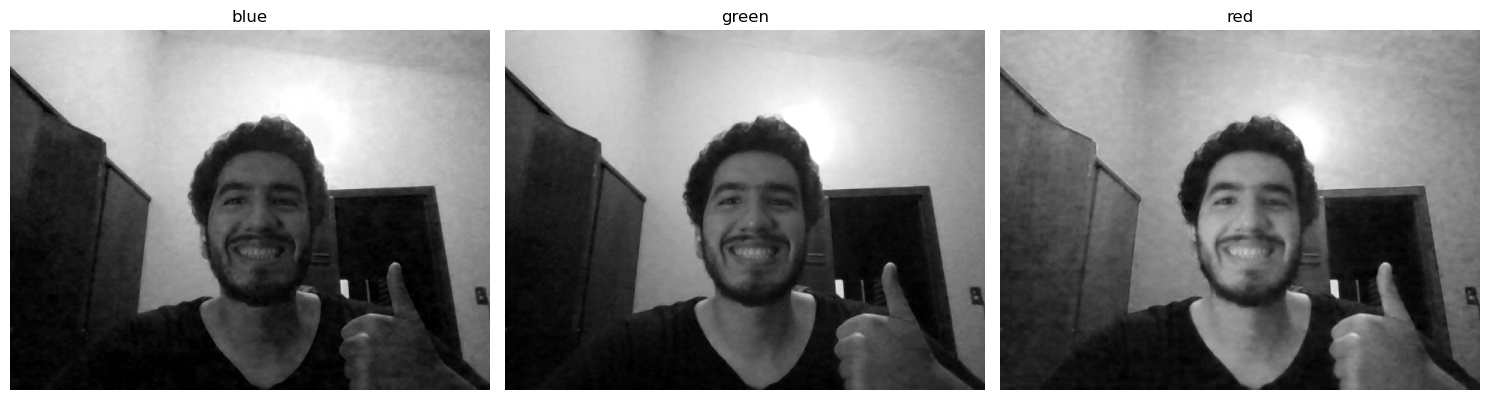

In [11]:
img = cv.imread(img_path)
copy_img = img.copy()
print(f'The selfie has {img.shape[0]} x {img.shape[1]} and {img.shape[2]} channels')

if img.shape[2]:
    channels = ['blue', 'green', 'red']
else:
    print("Check the channels")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i,c in enumerate(channels):
    img_path_c = img_path.replace(".jpg","_"+c+".jpg")
    cv.imwrite(img_path_c,img[:,:,i])
    axes[i].imshow(img[:,:,i], cmap='gray')
    axes[i].set_title(c)

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

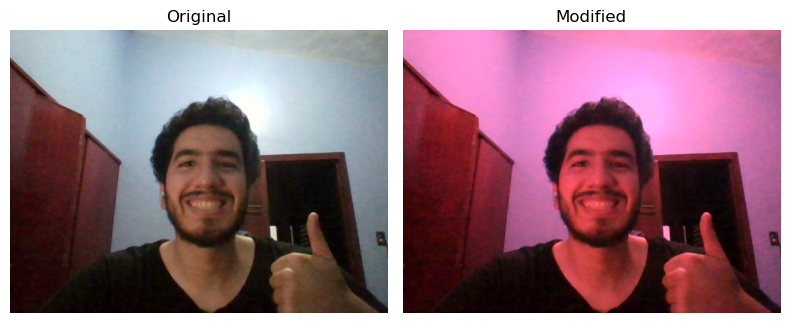

In [12]:
img[:,:,2] = np.minimum(copy_img[:,:,2] * 1.4, 255).astype(np.uint8) # RED
img[:,:,1] = np.maximum(copy_img[:, :, 1] /1.4 , 0).astype(np.uint8) # GREEN

img_path_mod = img_path.replace(".jpg","_modified1.jpg")
cv.imwrite(img_path_mod,img)
plot_img(2,(8,4),["Original", "Modified"],[copy_img, img])

### Convert to Gray Scale

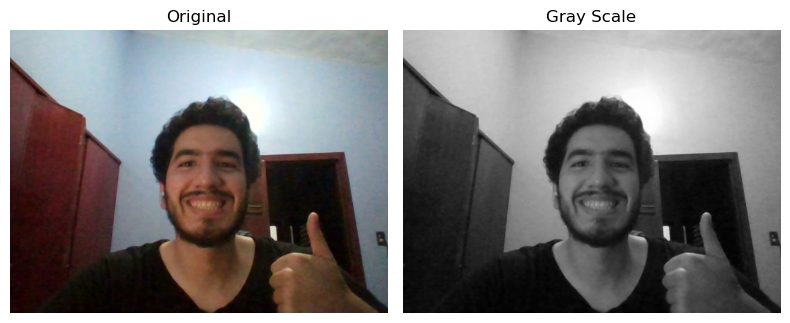

In [15]:
gray = cv.cvtColor(copy_img, cv.COLOR_BGR2GRAY)
img_path_gray = img_path.replace(".jpg","_gray.jpg")
cv.imwrite(img_path_gray,gray)

plot_img(2,(8,4),["Original", "Gray Scale"],[copy_img, gray])

### Invert the Gray Scale (Negative Image)

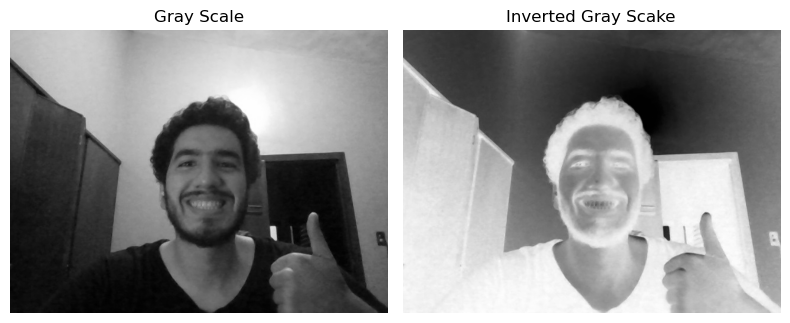

In [16]:
negative_gray = 255 - gray
plot_img(2,(8,4),["Gray Scale", "Inverted Gray Scake"],[gray, negative_gray])

### Change to HSV and display only the H channel
Here we will change the Color-space from BGR to HSV

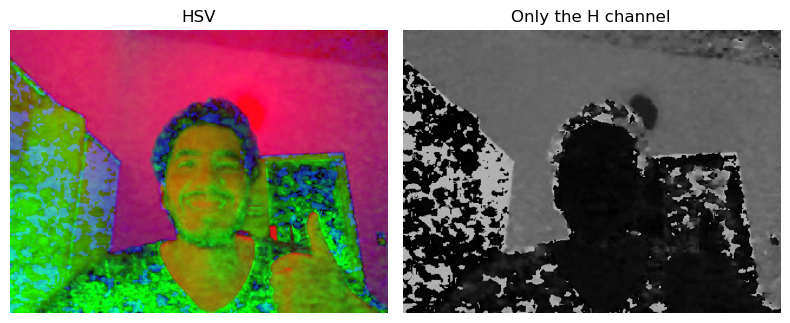

: 

In [18]:
hsv = cv.cvtColor(copy_img, cv.COLOR_BGR2HSV)
plot_img(2,(8,4),["HSV", "Only the H channel"],[hsv, hsv[:,:,0]])